In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

df_final = pd.read_csv('../data/processed/df_final_model2.csv')
df_teste = pd.read_json('../data/processed/df_final_model.json')

In [5]:
df_teste.head(2)

,processed_summary,sumarry_embedding,model_embedding,word_count,char_count,sentiment,is_recall,category_binary
0,ford knew issue back 2021 filed agency yet wai...,[-1.25882432e-01 9.36835334e-02 5.17301857e-...,"[0.040037598460912704, -0.27900347113609314, -...",80,518,0.091667,0,"[1, 1, 0, 0, 0]"
1,contact owns 2021 ford f 350 contact received ...,[-4.83598977e-01 -1.92022324e-01 2.60853291e-...,"[0.040037598460912704, -0.27900347113609314, -...",106,780,0.023333,1,"[0, 1, 1, 0, 0]"


In [6]:
import re
import ast

def clean_and_parse_embedding(embedding_str):
    # Remove extra whitespace and line breaks
    cleaned_str = embedding_str.strip().replace("\n", " ").replace("\t", " ")

    # Add commas between numbers if missing
    # This uses a regular expression to add a comma between numbers not already separated by whitespace or commas
    cleaned_str = re.sub(r'(?<=[\d\.\-e])\s+(?=[\d\-])', ', ', cleaned_str)

    try:
        # Convert cleaned string to a Python list
        embedding_list = ast.literal_eval(f'[{cleaned_str}]')
        return embedding_list
    except (SyntaxError, ValueError) as e:
        print(f"Error parsing string: {embedding_str[:100]}...")  # Print a preview of problematic strings
        return None

# Apply the function to the entire column
df_final["sumarry_embedding"] = df_final["sumarry_embedding"].apply(clean_and_parse_embedding)


In [7]:
import ast

def clean_embedding_string(embedding_str):
    if isinstance(embedding_str, list):
        # If the list is nested (e.g., [[...]]), flatten it
        if len(embedding_str) == 1 and isinstance(embedding_str[0], list):
            return embedding_str[0]  # Return the inner list
        return embedding_str  # Return as-is if not nested
    elif isinstance(embedding_str, str):
        # Clean and parse the string
        embedding_str = embedding_str.strip()
        if embedding_str.startswith("[[") and embedding_str.endswith("]]"):
            embedding_str = embedding_str[1:-1]
        return ast.literal_eval(embedding_str)
    else:
        raise ValueError(f"Unexpected data type: {type(embedding_str)}")

# Apply the function to the column
df_final["sumarry_embedding"] = df_final["sumarry_embedding"].apply(clean_embedding_string)


In [8]:
# Check the first few rows to ensure the transformation worked correctly
print(df_final["sumarry_embedding"].head())


0    [-0.125882432, 0.0936835334, 0.517301857, 0.01...
1    [-0.483598977, -0.192022324, 0.260853291, 0.10...
2    [-0.599698186, -0.106159344, 0.229459375, 0.00...
3    [-0.476734787, -0.0923845693, 0.257388443, 0.0...
4    [-0.129427716, -0.1638432, 0.359570444, -0.281...
Name: sumarry_embedding, dtype: object


In [9]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_final["processed_summary"])

topic_model = LatentDirichletAllocation(n_components=2, random_state=42)
topic_features = topic_model.fit_transform(tfidf_matrix)

topic_df = pd.DataFrame(topic_features, columns=[f"topic_{i+1}" for i in range(topic_features.shape[1])])
df_final = pd.concat([df_final, topic_df], axis=1)

In [10]:
df_final.drop(['processed_summary', 'sumarry_embedding', 'model_embedding', 'category_binary'], axis=1).corr()

,word_count,char_count,sentiment,is_recall,topic_1,topic_2
word_count,1.000000,0.991768,0.050435,0.208569,-0.099355,0.099355
char_count,0.991768,1.000000,0.049360,0.251131,-0.084355,0.084355
sentiment,0.050435,0.049360,1.000000,0.019249,0.298750,-0.298750
is_recall,0.208569,0.251131,0.019249,1.000000,0.271008,-0.271008
topic_1,-0.099355,-0.084355,0.298750,0.271008,1.000000,-1.000000
topic_2,0.099355,0.084355,-0.298750,-0.271008,-1.000000,1.000000


In [11]:
df_final.dtypes

processed_summary     object
sumarry_embedding     object
model_embedding       object
word_count             int64
char_count             int64
sentiment            float64
is_recall              int64
category_binary       object
topic_1              float64
topic_2              float64
dtype: object

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import ast

# Convert 'category_binary' column if necessary
df_final["category_binary"] = df_final["category_binary"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert embeddings and category binary column to NumPy arrays
X_embeddings = np.array(df_final["sumarry_embedding"].tolist()).squeeze()
y_category_binary = np.array(df_final["category_binary"].tolist())  # Ensure it's a 2D array

# Normalize additional features
additional_features = df_final[['word_count', 'char_count', 'sentiment', 'topic_1', 'topic_2']]
scaler = StandardScaler()
X_additional_features = scaler.fit_transform(additional_features)

# Split data into train and test sets
X_emb_train, X_emb_test, X_add_train, X_add_test, y_train, y_test = train_test_split(
    X_embeddings, X_additional_features, y_category_binary, test_size=0.2, random_state=42
)

# Verify the shapes of the data
print("X_emb_train shape:", X_emb_train.shape)  # Should match input shape for embedding input
print("X_add_train shape:", X_add_train.shape)  # Should match input shape for additional input
print("y_train shape:", y_train.shape)          # Should be (num_samples, 5) if 5 labels are expected


X_emb_train shape: (10731, 768)
X_add_train shape: (10731, 5)
y_train shape: (10731, 5)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define inputs
embedding_input = Input(shape=(X_emb_train.shape[1],), name="embedding_input")
additional_input = Input(shape=(X_add_train.shape[1],), name="additional_input")

# Embedding branch with batch normalization and L2 regularization
x1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(embedding_input)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)

# Additional features branch with batch normalization and L2 regularization
x2 = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(additional_input)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)

# Combine both branches
combined = Concatenate()([x1, x2])
combined = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.5)(combined)

# Output layer for multi-label classification
output = Dense(5, activation='sigmoid')(combined)

# Define the model
model = Model(inputs=[embedding_input, additional_input], outputs=output)

optimizer = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Recall','Precision'])

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define the path to save the best model
best_model_path = "best_model.h5"

# Add the ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,  # Path to save the model
    monitor='val_loss',        # Monitor the validation loss
    save_best_only=True,       # Save only when the validation loss improves
    mode='min',                # Save when the monitored metric is minimized
    verbose=1                  # Print message when saving the model
)

# Train the model
history = model.fit(
    {"embedding_input": X_emb_train, "additional_input": X_add_train},
    y_train,
    validation_data=({"embedding_input": X_emb_test, "additional_input": X_add_test}, y_test),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
82/84 [============================>.] - ETA: 0s - loss: 2.3259 - accuracy: 0.2661 - auc: 0.5629 - recall: 0.5485 - precision: 0.2936
Epoch 1: val_loss improved from inf to 1.88392, saving model to best_model.h5
84/84 [==============================] - 3s 20ms/step - loss: 2.3193 - accuracy: 0.2663 - auc: 0.5639 - recall: 0.5489 - precision: 0.2937 - val_loss: 1.8839 - val_accuracy: 0.2650 - val_auc: 0.6259 - val_recall: 0.4767 - val_precision: 0.3298
Epoch 2/50
81/84 [===========================>..] - ETA: 0s - loss: 1.7594 - accuracy: 0.3666 - auc: 0.6525 - recall: 0.6026 - precision: 0.3532
Epoch 2: val_loss improved from 1.88392 to 1.48506, saving model to best_model.h5
84/84 [==============================] - 1s 16ms/step - loss: 1.7523 - accuracy: 0.3667 - auc: 0.6529 - recall: 0.6019 - precision: 0.3539 - val_loss: 1.4851 - val_accuracy: 0.3902 - val_auc: 0.7176 - val_recall: 0.4882 - val_precision: 0.4600
Epoch 3/50
83/84 [============================>.] - ETA: 0s - 

In [55]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define input
embedding_input = Input(shape=(X_emb_train.shape[1],), name="embedding_input")

# Embedding branch with batch normalization and L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.02))(embedding_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(16, activation='relu', kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer for multi-label classification
output = Dense(5, activation='sigmoid')(x)

# Define the model
model = Model(inputs=embedding_input, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Métrica a ser monitorada
    factor=0.5,          # Reduz o learning rate pela metade
    patience=3,          # Reduz o LR após 3 épocas sem melhoria
    min_lr=1e-6          # Limite mínimo para o learning rate
)

# Add early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

best_model_path = "best_model_embeddings_only.h5"
model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(
    X_emb_train,
    y_train,
    validation_data=(X_emb_test, y_test),
    epochs=150,
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)


Epoch 1/150
84/84 [==============================] - ETA: 0s - loss: 6.4844 - accuracy: 0.2122 - auc: 0.5147 - recall: 0.5197 - precision: 0.2665
Epoch 1: val_loss improved from inf to 5.91012, saving model to best_model_embeddings_only.h5
84/84 [==============================] - 3s 21ms/step - loss: 6.4844 - accuracy: 0.2122 - auc: 0.5147 - recall: 0.5197 - precision: 0.2665 - val_loss: 5.9101 - val_accuracy: 0.1737 - val_auc: 0.5466 - val_recall: 0.3416 - val_precision: 0.2763 - lr: 1.0000e-04
Epoch 2/150
84/84 [==============================] - ETA: 0s - loss: 5.8973 - accuracy: 0.2321 - auc: 0.5372 - recall: 0.5331 - precision: 0.2773
Epoch 2: val_loss improved from 5.91012 to 5.39068, saving model to best_model_embeddings_only.h5
84/84 [==============================] - 1s 17ms/step - loss: 5.8973 - accuracy: 0.2321 - auc: 0.5372 - recall: 0.5331 - precision: 0.2773 - val_loss: 5.3907 - val_accuracy: 0.2188 - val_auc: 0.5538 - val_recall: 0.4244 - val_precision: 0.2968 - lr: 1.000

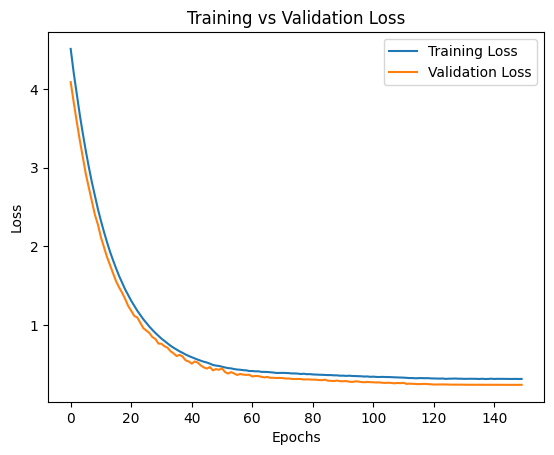

In [52]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


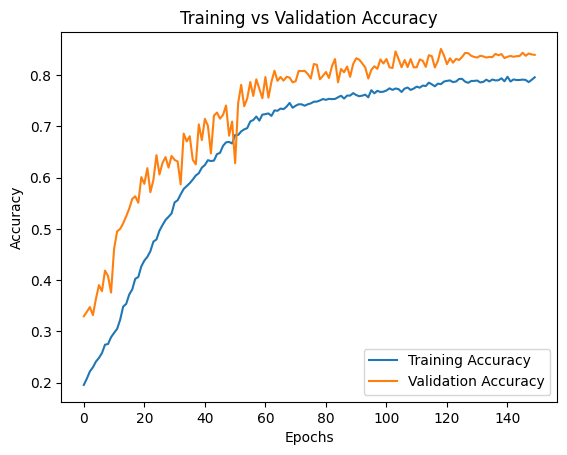

In [53]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


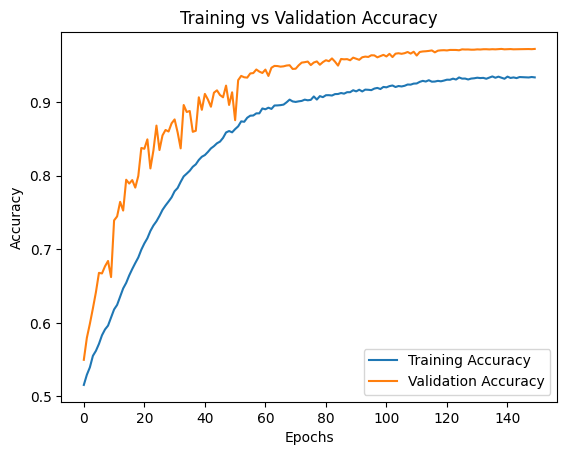

In [54]:
# Plot training and validation accuracy
plt.plot(history.history['auc'], label='Training Accuracy')
plt.plot(history.history['val_auc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [20]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Generate predictions
y_pred = model.predict({"embedding_input": X_emb_test, "additional_input": X_add_test})
y_pred = (y_pred > 0.5).astype(int)

# Multilabel confusion matrix
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Display classification report
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']))


84/84 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Class 1       0.83      0.82      0.82       873
     Class 2       0.93      0.66      0.77      1007
     Class 3       0.79      0.43      0.56       719
     Class 4       0.69      0.81      0.75       334
     Class 5       0.69      0.58      0.63       545

   micro avg       0.81      0.65      0.72      3478
   macro avg       0.79      0.66      0.71      3478
weighted avg       0.82      0.65      0.72      3478
 samples avg       0.77      0.71      0.72      3478



c:\Users\dighz\anaconda3\envs\ford_case5\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


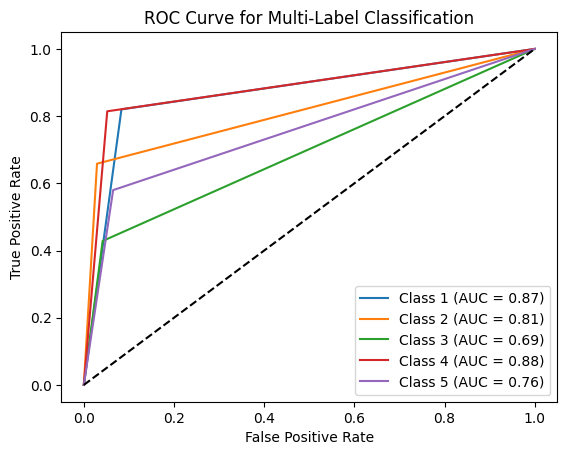

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output (for multi-label ROC)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Label Classification')
plt.legend(loc='lower right')
plt.show()


In [29]:
# Plot learning rate over epochs (if applicable)
lrs = [x['lr'] for x in history.history['lr']]
plt.plot(lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Scheduler')
plt.show()


KeyError: 'lr'

In [30]:
import matplotlib.pyplot as plt

# Simulação para diferentes LR's
lrs = [1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
losses = []

for lr in lrs:
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_emb_train, y_train, batch_size=32, epochs=3, verbose=0)
    losses.append(history.history['loss'][-1])

# Plotting
plt.plot(lrs, losses, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')
plt.show()


ValueError: in user code:

    File "c:\Users\dighz\anaconda3\envs\ford_case5\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\dighz\anaconda3\envs\ford_case5\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\dighz\anaconda3\envs\ford_case5\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\dighz\anaconda3\envs\ford_case5\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\dighz\anaconda3\envs\ford_case5\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\dighz\anaconda3\envs\ford_case5\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 768) dtype=float32>]
